* START -> Outline Generator -> Blog Generator -> Evaluator -> END 

* in evaluate node we can put a prompt such as -> based on generated outline rate the blog and generate a score from 1 to 5

In [3]:
import os
from langgraph.graph import StateGraph, START, END
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict

In [17]:
# build a state for graph

class BlogState(TypedDict):
  topic: str 
  outline: str 
  blog: str 
  Evaluation: str

In [18]:
## build a fn for outline generator node 

def outline_generator(state:BlogState)->BlogState:

  llm= HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-1.5B-Instruct",
    task="text-generation",
    huggingfacehub_api_token= os.getenv("HUGGINGFACEHUB_API_TOKEN")
  )

  model= ChatHuggingFace(llm= llm)

  prompt= PromptTemplate(
    template="Generate outline of this topic {topic}",
    input_variables=['topic']
  )

  parser= StrOutputParser()

  chain= prompt|model|parser

  outline= chain.invoke(state)

  state['outline']= outline

  return state 

## build a fn for blog generator node

def blog_generator(state: BlogState)->BlogState:

  llm= HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-1.5B-Instruct",
    task="text-generation",
    huggingfacehub_api_token= os.getenv("HUGGINGFACEHUB_API_TOKEN")
  )

  model= ChatHuggingFace(llm= llm)

  prompt= PromptTemplate(
    template="Generate a blog about this topic -> {topic} and use this outline-> \n {outline}",
    input_variables=['topic', 'outline']
  )

  parser= StrOutputParser()

  chain= prompt|model|parser
  blog= chain.invoke(state)

  state['blog']= blog

  return state 

## now create a fn for evaluation node 

def evaluator(state: BlogState)->BlogState:

  llm= HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-1.5B-Instruct",
    task= "text-generation",
    huggingfacehub_api_token=os.getenv("HUGGINGFACEHUB_API_TOKEN")
  )

  model= ChatHuggingFace(llm= llm)

  prompt= PromptTemplate(
    template="Evaluate the generated blog - {blog} \n about topic - {topic} and outline - \n {outline} \n and try to rate it out of 1 to 5",
    input_variables=['blog', 'topic', 'outline']
  )

  parser= StrOutputParser()

  chain = prompt|model|parser 

  result= chain.invoke(state)

  state['Evaluation']= result

  return state

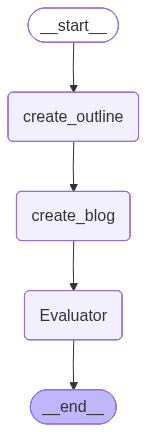

In [19]:
## build a graph
graph= StateGraph(BlogState)

## add node 
graph.add_node('create_outline', outline_generator)
graph.add_node('create_blog', blog_generator)
graph.add_node('Evaluator', evaluator)

## add edges 
graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline', 'create_blog')
graph.add_edge('create_blog', "Evaluator")
graph.add_edge('Evaluator', END)

# compile 
workflow= graph.compile()
workflow

In [20]:
intial_state= {'topic':"History of cat"}

final_state= workflow.invoke(intial_state)
final_state

{'topic': 'History of cat',
 'outline': 'Sure! Here is a suggested outline for the topic "History of the Cat":\n\nI. Introduction to Cats\n   A. History of Cats in Ancient Civilizations\n      1. Spotted Felines in Ancient Egypt\n      2. Mitochondrial DNA Analysis of Ancient Mummies\n      3. The Minoan Cats of Crete\n   B. Early Domestication of Cats\n      1. The Flea Theory\n      2. Cat Domestication in Europe\n   C. The Other Cats: Wild Strays and Beyond\n      1. The Feral Cat Crisis\n      2. The Tasmanian Tiger and Other Feral Predators\n\nII. The Domestication of Cats Across Cultures\n   A. Cat Worship in Ancient China\n      1. The Dragon Goddess and the Cat\n      2. The Cat Goddess Miao\n   B. Cat Worship in Ancient Japan\n      1. The Cat Worship of the Nara Period\n      2. The Cat in Japanese Mythology\n   C. Cat Worship in Ancient Greece and Rome\n      1. The Cat in Greek Mythology\n      2. The Cat in Roman Culture\n\nIII. The Evolution of Cat Domestication in Europe

In [21]:
final_state['Evaluation']

'5/5\n\nThis outline is comprehensive and well-structured, providing a clear and detailed look at the history of cats from their ancient origins in Egypt to modern-day breeds and their role in human society. It covers a wide range of topics, including cat worship across cultures, the domestication process, the role of cats in various societies, and the development of cat breeding. The outline is logical and easy to follow, making it an excellent starting point for any blog post about the history of cats.'